# Задание №1

Создайте модель на основе LSTM для прогнозирования будущих значений временного ряда, такого как акции компании, погода или продажи продукта.

Подготовка данных: Выберите любой временной ряд (ВНИМАНИ!) используйте данные, которые вы сами обнаружите в интернете или на платформе Kaggle, которые хотите анализировать. Произведите разделение на обучающую и тестовую выборки, а также нормализацию данных, если необходимо.

Построение модели LSTM: архитектуру сети с одним или несколькими слоями LSTM. 

Обучение модели: Обучите модель на обучающей выборке, используя подходящую функцию потерь и оптимизатор.

Прогнозирование и оценка: Произведите прогнозирование на тестовой выборке и оцените качество прогноза с использованием подходящих метрик, таких как среднеквадратичная ошибка (MSE).

Визуализация: Визуализируйте реальные и прогнозируемые значения временного ряда на графиках для наглядного сравнения.

In [1]:
#!pip install --upgrade mplfinance

In [2]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# Для обработки
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# Для визуализации
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Для обучения модели
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


### Предобработка

In [4]:
# дропаем лишнюю колонку Unnamed
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
# Определение функции, которая будет содержать данные о акциях для конкретной компании
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [6]:
# Выбор случайной компании из столбца 'Name'
company_name = random.choice(df['Name'].unique().tolist())
# Устанавливаем начало и конец дат
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Вызов функции specific_data
specific_df = specific_data(company_name, start_date, end_date)
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
26061,Danone,2019-12-30,74.66,74.16,74.66,74.12,284
26062,Danone,2019-12-27,74.16,74.90,74.90,74.16,23
26063,Danone,2019-12-23,74.66,74.42,74.66,74.42,943
26064,Danone,2019-12-20,73.90,74.60,74.60,73.90,"1,355"
26065,Danone,2019-12-19,73.96,73.56,73.96,73.56,296


### Визуализация

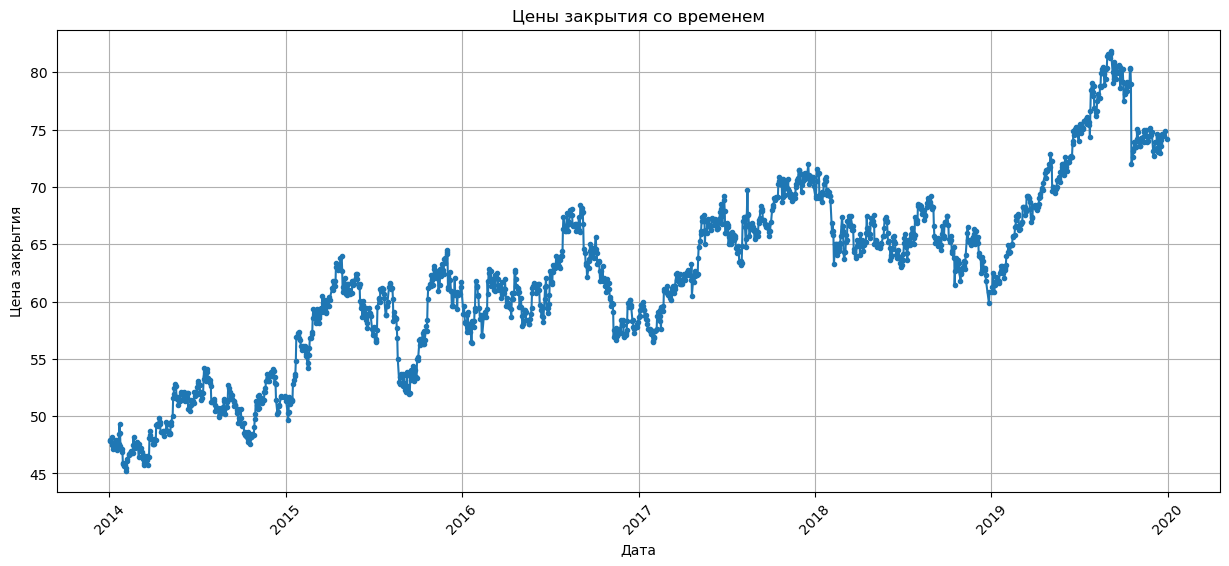

In [44]:
# Преобразование даты в datatime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Цены закрытия со временем')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

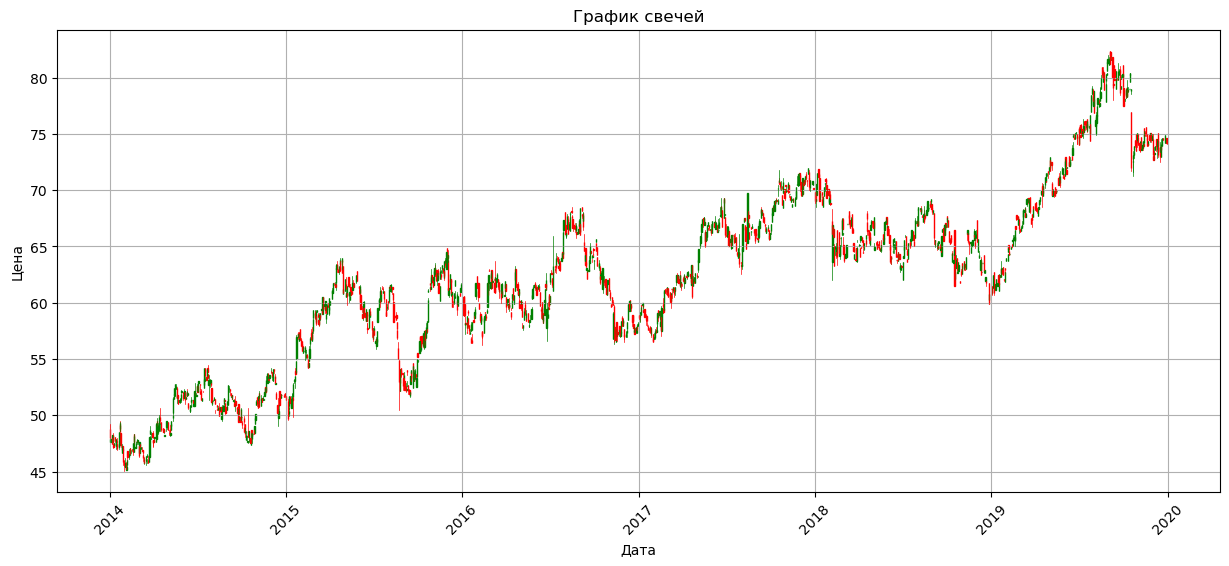

In [46]:
# Для более удобного формата визуализации преобразуем в "свечной формат"
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('График свечей')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

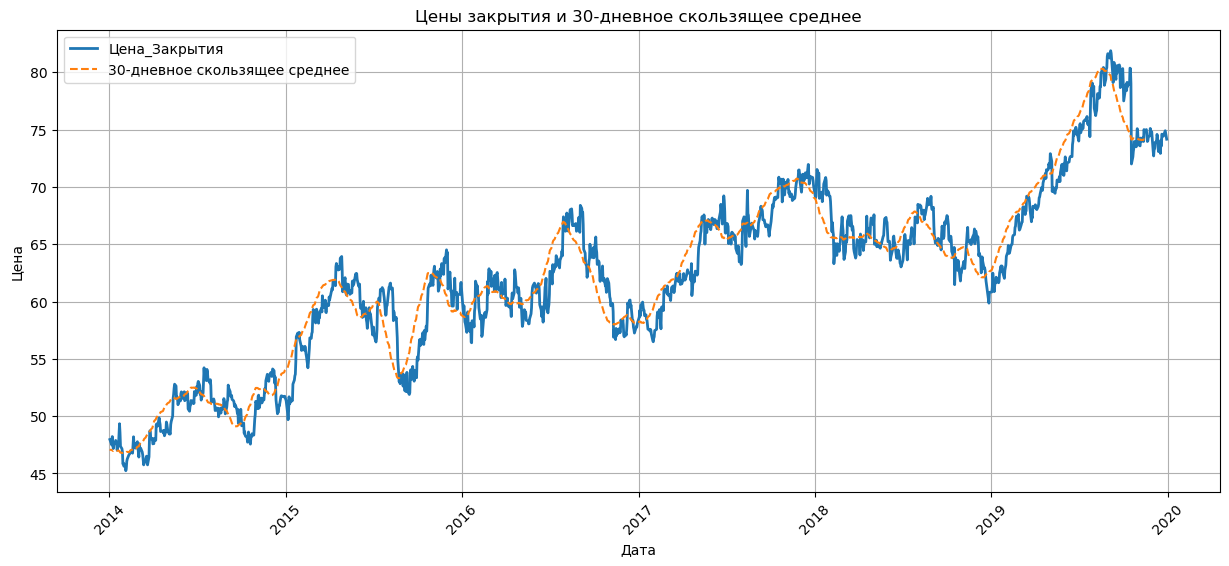

In [43]:
# График закрытия цен и скользящей средней
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Цена_Закрытия', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-дневное скользящее среднее', linestyle='--')
plt.title(f'Цены закрытия и {window}-дневное скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

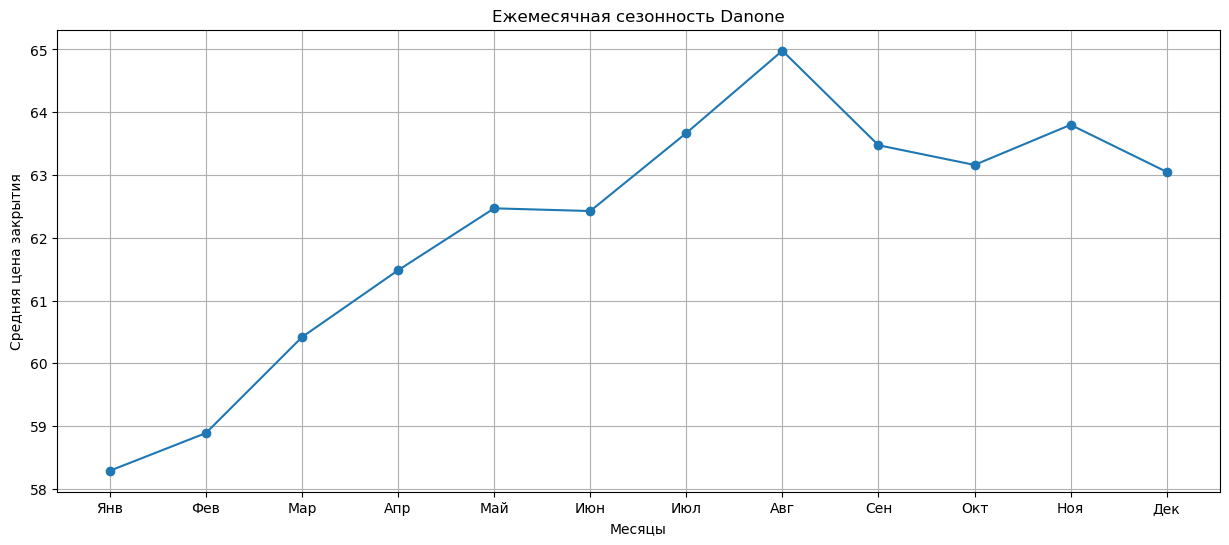

In [39]:
# Ежемесячная сезонность закрытия цен
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Ежемесячная сезонность {company_name}')
plt.xlabel('Месяцы')
plt.ylabel('Средняя цена закрытия')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(True)
plt.show()

In [14]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
26061,Danone,2019-12-30,74.66,74.16,74.66,74.12,284,12
26062,Danone,2019-12-27,74.16,74.90,74.90,74.16,23,12
26063,Danone,2019-12-23,74.66,74.42,74.66,74.42,943,12
26064,Danone,2019-12-20,73.90,74.60,74.60,73.90,"1,355",12
26065,Danone,2019-12-19,73.96,73.56,73.96,73.56,296,12


In [15]:
new_df = specific_df.reset_index()['Closing_Price']

In [16]:
# Нормализуем наш датафрейм при помощи MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [17]:
# Разделяем на тренировочную и тестовую выборки
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [18]:
# Определение длины последовательности (количество прошлых временных шагов)
n_past = 60

# Подготовка последовательностей для LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Подготовка последовательности для тестового набора данных
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [21]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("-"*20)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)
--------------------
Testing set size:-
(243, 60)
(243,)


(None, None)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Построение модели

In [26]:
# Инициализация последовательной модели
model = Sequential()

# Первый слой LSTM с 50 единицами, входной формой и возвратом последовательностей
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Второй слой LSTM с 50 единицами и возвратом последовательностей
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Третий слой LSTM с 50 единицами
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Добавление плотного выходного слоя с одним нейроном
model.add(Dense(units=1))

model.summary()

model.compile(loss='mean_squared_error',optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [27]:
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Обучение модели LSTM
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 [==============================] - 4s 37ms/step - loss: 0.0344 - val_loss: 0.0106
Epoch 2/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 3/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 4/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 5/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 6/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 7/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 8/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 9/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 10/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0034

36/36 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 4.5502e-04
Epoch 82/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 4.2807e-04
Epoch 83/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 84/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 9.8258e-04
Epoch 85/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 86/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 87/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 5.1607e-04
Epoch 88/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 9.7396e-04
Epoch 89/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 4.1180e-04
Epoch 90/100
36/36 [==============================] - 1s 20ms/step - loss: 0.001

In [28]:
# Выполним прогноз и проверим метрики производительности
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 6ms/step


In [29]:
# Преобразуем обратно в исходную форму
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [34]:
# Calculate train data RMSE
print(f'RMSE_train: {math.sqrt(mean_squared_error(y_train,train_predict))}')
print('-'*30)
# Calculate test data RMSE
print(f'RMSE_test: {math.sqrt(mean_squared_error(y_test,test_predict))}')
print('-'*30)
# Calculate train data MSE
print(f'MSE_train: {mean_squared_error(y_train,train_predict)}')
print('-'*30)
# Calculate test data MSE
print(f'MSE_test: {mean_squared_error(y_test,test_predict)}')

RMSE_train: 63.72615272146288
------------------------------
RMSE_test: 50.64361468988733
------------------------------
MSE_train: 4061.0225406792106
------------------------------
MSE_test: 2564.7757088577714


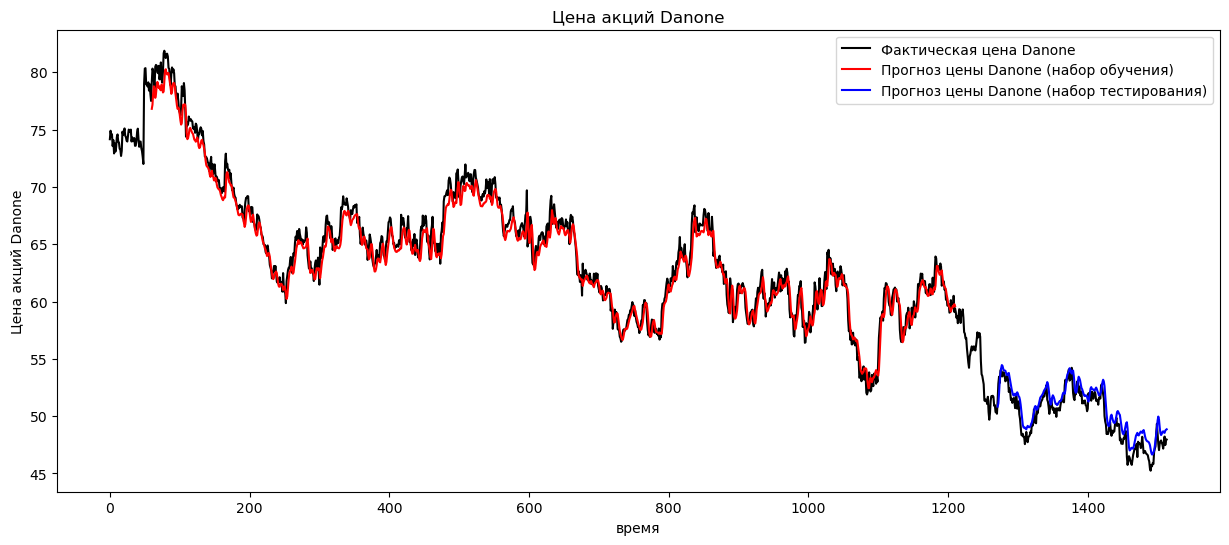

In [35]:
# Задаем количество предыдущих временных шагов для построения графика
look_back = 60

# Инициализация массива для построения прогнозов на обучающем наборе данных
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Присваиваем предсказанные значения на соответствующие места на графике для обучающего набора данных
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Инициализация массива для построения прогнозов на тестовом наборе данных
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Вычисляем начальный индекс для прогнозов на тестовом наборе данных
test_start = len(new_df) - len(test_predict)
# Присваиваем предсказанные значения на соответствующие места на графике для тестового набора данных
testPredictPlot[test_start:] = test_predict.flatten()

# Возвращаем масштабированные данные обратно к их исходной шкале с использованием масштабировщика
original_scaled_data = scaler.inverse_transform(scaled_data)

# Построение базовых данных, прогнозов на обучающем наборе данных и прогнозов на тестовом наборе данных
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Фактическая цена {company_name}")
plt.plot(trainPredictPlot, color='red', label=f"Прогноз цены {company_name} (набор обучения)")
plt.plot(testPredictPlot, color='blue', label=f"Прогноз цены {company_name} (набор тестирования)")

plt.title(f"Цена акций {company_name}")
plt.xlabel("время")
plt.ylabel(f"Цена акций {company_name}")
plt.legend()
plt.show()
plt.show()

In [47]:
# Чтобы сделать прогноз на следующие 10 дней, вам понадобятся данные о последних днях
last_sequence = X_test[-1]

# Изменим форму последней последовательности, чтобы она соответствовала входной форме модели
last_sequence = last_sequence.reshape(1, n_past, 1)

# Генерация прогнозов на следующие 10 дней
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Преобразуем прогнозы обратно в исходную шкалу
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Вывод прогнозов на следующие 10 дней
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 10ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 48.85369110107422
Day 2: Predicted Price = 49.14306640625
Day 3: Predicted Price = 49.593936920166016
Day 4: Predicted Price = 50.09693145751953
Day 5: Predicted Price = 50.59691619873047
Day 6: Predicted Price = 51.07332229614258
Day 7: Predicted Price = 51.51921081542969
Day 8: Predicted Price = 51.93229675292969
Day 9: Predicted Price = 52.31241989135742
Day 10: Predicted Price = 52.660892486572266


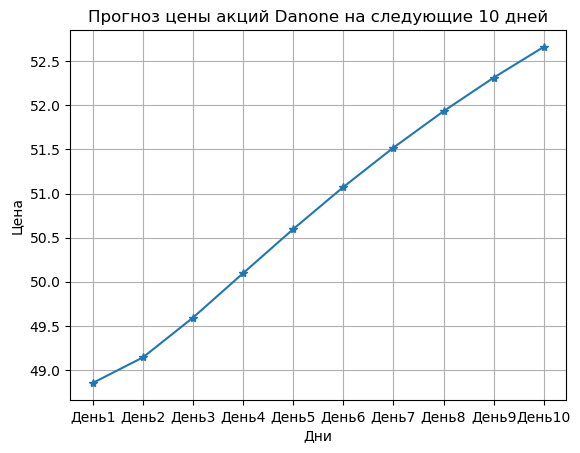

In [48]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Прогноз цены акций {company_name} на следующие 10 дней')
plt.xlabel('Дни')
plt.ylabel('Цена')
plt.xticks(range(0, 10), ['День1', 'День2', 'День3', 'День4', 'День5', 'День6', 'День7', 'День8', 'День9', 'День10'])
plt.grid(True)
plt.show()